# LMS distortion



In [16]:
from pylab import *
from astropy.io.fits import open as fo
from IPython.display import Image, display

The following is a summary of the steps that were taken to apply the CRIRES+ data reduction to simulation the METIS LMS IFU.
* ScopeSim runs
* Insert data into CRIRES frames
* Order tracing
* Tilt determination
* Extracting 1D spectra
* Assigning Wavelength and spatial scale to pixels in 2D spectra

## ScopeSim
As of april 2022, when these simulations were carried out, the release-version of the simulator did not support the IFU mode of METIS. Therefore a development version of the LMS-branch was istalled, after instructions from the team. The mode was set such that the 
The scipt that creates the frame with the sky spectrum is called `lms_sky.py` and does very little besides calling the simulator with default arguments, and istructing it to set the central wavelength of the spectrograph to arbitrary 3.55micon.
In addition, it retrieves the wavelength scale from one of the slices, in order to later ingest it into the CRIRES-pipeline.

## CRIRES DRS
The upgraded CRIRES is a cross-dispersed echelle slit-spectrograph for the near-infrared bands YJHKLM. It uses three of the same HAWAII2RG detectors that the METIS will use four of. The fact that CRIRES images several spectral orders while METIS does slices of spatial regions, is not no hindrance to applying the same methods for finding the location and shape of each order/slice in the detector grid, and to determine the orientation of the "slit".

The CRIRES DRS is a standard ESO-pipeline that was developped from scratch for the upgraded instrument and is in operation since late 2021. It can be installed from the usual sources for ESO pipelines on their website, no particular version is needed for this exercise since the basic algorithms have not changed.

ScopeSim produces frames for all four of the LMS detectors. Simply ignoring the fourth, the pixel values were copied into a raw frame CRIRES, thus preserving its headers and replacing the data.

## Order tracing
By "trace" we mean the polynomial in detector coordinates (x,y) that describes the mid-line of the spectral order. This is done by smoothing and thresholding the sky frame (which has enough continuum) in order to distinguish in-order from inter-order pixels. Continuous clusters of in-order pixels are then fitted with a second-degree polynomial.
The command executed was

    # esorex cr2res_util_trace trace_sky.sof
    
, where `trace_sky.sof` contains only one line, pretending the sky frame is a FLAT (which is what is usually used for tracing)

    CIRES_sky.fits FLAT
    
The output file is `CIRES_sky_tw.fits` which is a table that now has the traces for each slice. In addition to the mid-line, it also has the polynomials for the upper and lower edges of each slice.

## Slit tilt
Next up is measuring the orientation of the "slit" in each slice, i.e. the tilt of spectral lines w.r.t. the detector columns. Using the trace from the previous step, each slice gets rectified by shifting columns by integer values according to the trace.
Then a peak-finder is run on each row to find spectral lines, which are then fitted with Gaussians to determine their line centers. Comparing how the line-centers change with detector rows, allows us to fit the slit tilt as a polynomyal P(y). In order to reject outliers and ensure a smooth change in the tilt, the *coefficients* of the tilt polynomials are then each fit as P(x).
These coefficients are saved in an updated FITS-table, called `CIRES_sky_tw_tw.fits`. Using the included script that evaluates the polynomials and plots them on top of the sky frame, we can have a look at the result.

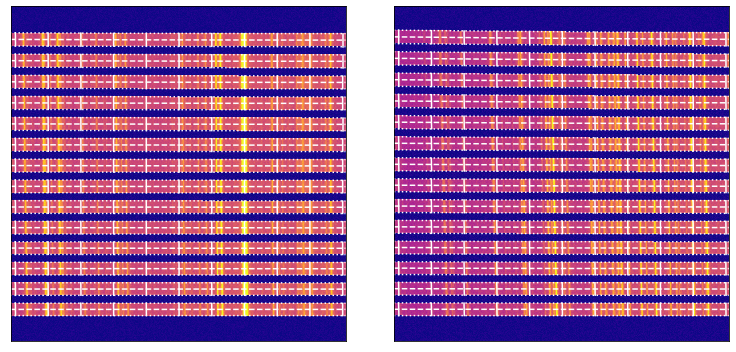

In [3]:
%run show_trace_curv.py CIRES_sky_tw_tw.fits CIRES_sky.fits # only plots the top two detectors

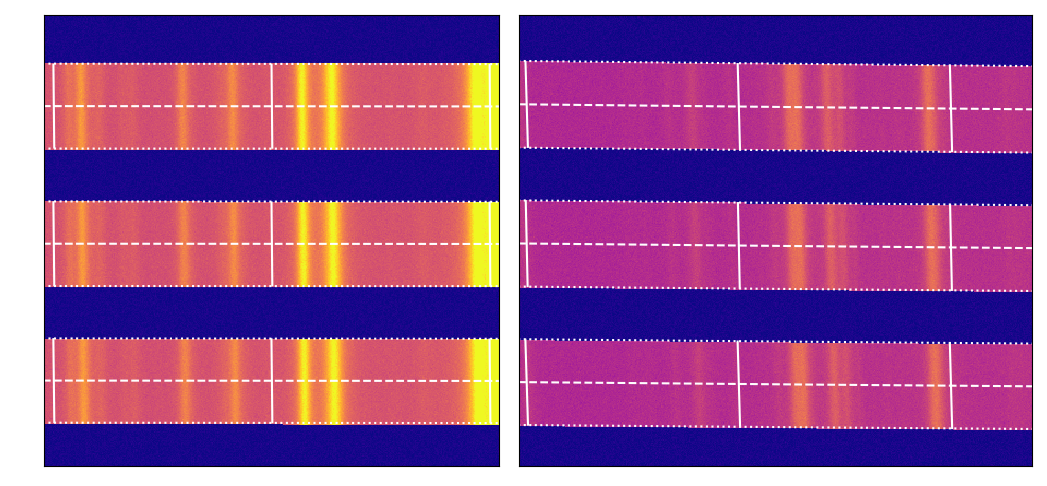

In [17]:
# Zooming in allows to perceive the tilt in the regularly plotted vertical lines that align with the data.
display(Image(filename='lms_sky_tracetilt_zoom.png'))

In [6]:
tilts = fo('CIRES_sky_tw_tw.fits')[1].data['SlitPolyB']
tilts

array([[-1.45030918e-02,  4.97644175e-06, -8.81093015e-10],
       [-1.71465266e-02,  1.19526702e-05, -4.11230539e-09],
       [-1.60470680e-02,  9.62834066e-06, -2.46179182e-09],
       [-1.56843290e-02,  1.04739179e-05, -3.39557250e-09],
       [-9.89049691e-03, -7.80064422e-07,  1.55907143e-09],
       [-1.37041189e-02,  7.36109573e-06, -1.76092183e-09],
       [-1.21335419e-02,  3.73431498e-06,  3.62338925e-10],
       [-9.88651568e-03,  1.90595104e-06,  9.70922842e-10],
       [-1.25626738e-02,  9.42000943e-06, -3.06478176e-09],
       [-1.23701034e-02,  4.81279417e-06,  6.75878571e-10],
       [-1.30267035e-02,  9.46268944e-06, -2.61068479e-09],
       [-9.47728454e-03,  3.20871517e-06,  1.27630431e-09],
       [-1.29999200e-02,  1.02179873e-05, -1.89150864e-09],
       [-1.04358752e-02,  2.52729614e-06,  1.30881039e-09]])

When we evaluate one of the polynomials at the detector edges and center, we find that the slit angle varies between 0.5 and 0.9 degrees.

In [13]:
dx=polyval(tilts[3][::-1],[1,1024,2048]) # reverse order of coeffs in python
dx

array([-0.01567386, -0.00851955, -0.00847581])

In [14]:
degrees(arctan(dx)) # Tilt angles

array([-0.89797241, -0.48812261, -0.48561642])

In [18]:
dx*80 # pixel difference between top and bottom of a slice, ~80pix high

array([-1.25390868, -0.68156423, -0.67806467])

## Extracting into 1D spectra

### Fake wavelengths
Before we use the "TW"-table from above to extract 1D-spectra, we need to fix the wavelength scale that is also part of the table (TW stands for TraceWave-table in CRIRES-lingo), because otherwise the spectra would have a totally wrong wavelengh scale. For simplicity, the numbering of the METIS slices was not matched with the CRIRES numbering of orders, instead we set the wavelength of one slice (saved into `lam_1.npy` by the script above) for all spectra of the same detector.

In [29]:
tw=fo('CIRES_sky_tw_tw.fits')
for detec in [1,2]:
    lam=np.load('lam_%d.npy'%detec)
    x=arange(len(lam))+1 
    p=polyfit(x,lam,2)[::-1]
    print(p)
    for row in tw['CHIP%d.INT1'%detec].data:
        row['Wavelength']=p
tw.writeto(tw.filename(),overwrite=True)

[ 3.55110788e+00  1.28761289e-05 -5.17343629e-11]
[ 3.52304458e+00  1.29677244e-05 -2.01943107e-11]


The following command runs the optimal extraction which collapses the full height of each slice into a 1D-spectrum, taking the trace and slit tilt into account and iterating to minimize the residual error. (We arbitrarily select "order #3"; again this is CRIRES-numbering and has no meaning for the purpose of this exercise.)

    # esorex cr2res_util_extract --detector=1 --order=3 --trace=1 extract_sky.sof

Now we can plot the spectrum from SkyCalc, that was used by ScopeSim, against the our extracted spectrum. For size considerations, the input sky spectrum is not included in this package and we display the pre-made figure here.

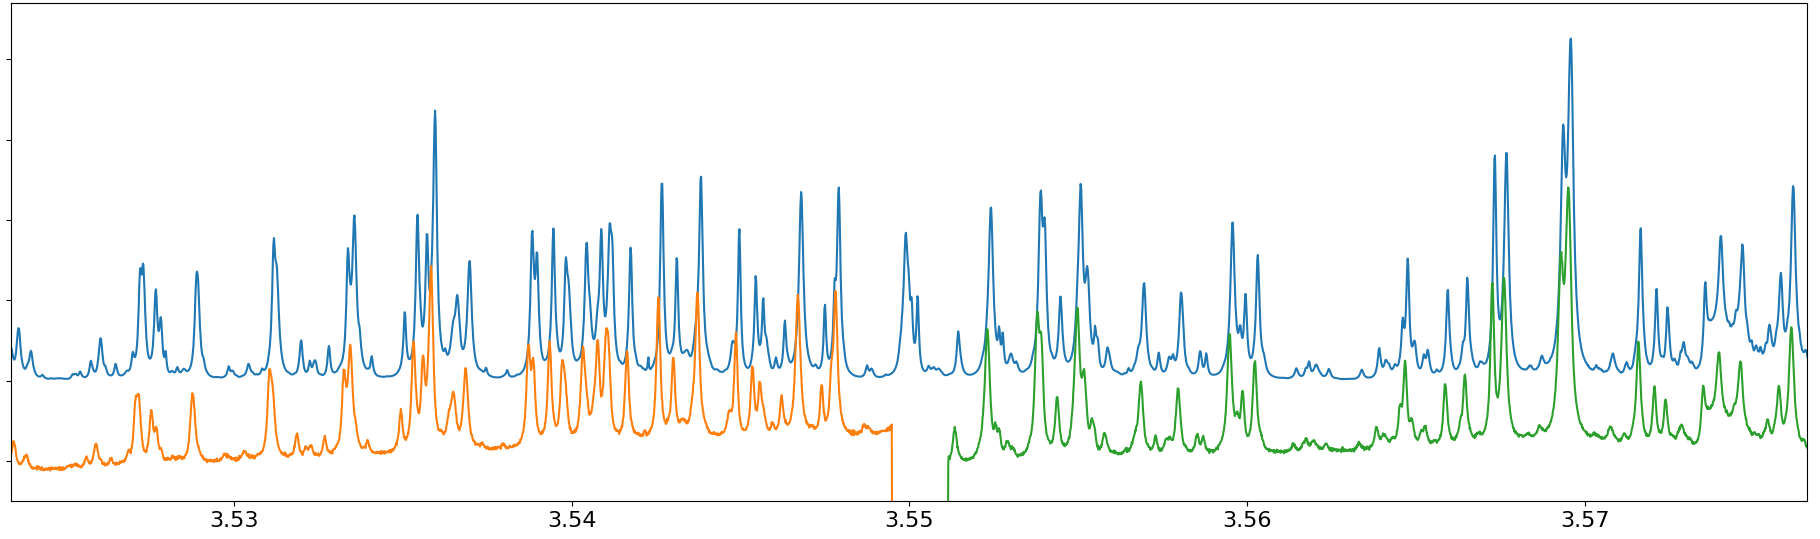

In [20]:
display(Image(filename='lms_skyrecover.png'))

In blue the input spectrum, in orange and green the spectra from the two detectors that cover the slice. Vertical offset and scaling are arbitrary. The slight offset in wavelength is due to the mismatch in slice number between the assigned wavelength and the one that got extracted. This nicely illustrates the task of the wavelength calibration, namely to determine this shift by cross-correlation, but this in not part of the current exercise.

## 2D spectra
Collapsing slices (or parts of one) into 1D spectra is certainly useful, not the least for calibrations. But METIS is all about spatial resolution, of course, so this whole exercise would be incomplete without assigning to each pixel a wavelength and a speatial coordinate along the slice.
Luckily, this is quite straight-forward from the information in the TW-table. The polynomials for the slice edges and mid-line, together with the known on-sky length of the slice, define the position of each pixel on the sky. To arrive at the correct wavelenth, one evaluates the slit-tilt polynomial at the current pixel's distance from the mid-line, to get the displacement in dispersion direction. Then this delta-x gets converted to delta-lambda using the wavelength solution.

In [30]:
# plot missing, otherwise more-or-less done.

Any non-linear spatial distortion along the slice, as measured from the full field-of-view of the LM-Imager, or by illuminating the IFU slices with the grid of the pin-hole mask in the WCU, can be added to the spatial scale as a last step.